In [1]:
import torch

def get_device():
    if torch.cuda.is_available():       
        device = torch.device("cuda")
        print('There are %d GPU(s) available.' % torch.cuda.device_count())
        print('We will use the GPU:', torch.cuda.get_device_name(0))
    else:
        device = torch.device("cpu")
        print('No GPU available, using the CPU instead.')

    return device

device = get_device()

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [3]:
if IN_COLAB:
    PATH_TO_DATA = '/content/'
else:
    PATH_TO_DATA = './data/'

# Copy data 

In [5]:
BASE_PATH = '/content/drive/MyDrive/ai/detect-flood-water/'

In [6]:
!ls {BASE_PATH}

cv_results.ipynb	flood-training-metadata.csv  training_results.ipynb
detect-flood-water	flood-train-labels.tgz
flood-train-images.tgz	pth_save


In [7]:
%%time
file_name = 'flood-train-images.tgz'
file_path = BASE_PATH + file_name
local_path = f'./{file_name}'

!cp {file_path} .
!tar -xvf {local_path} > /dev/null

CPU times: user 119 ms, sys: 37.6 ms, total: 157 ms
Wall time: 21.6 s


In [8]:
%%time
file_name = 'flood-train-labels.tgz'
file_path = BASE_PATH + file_name
local_path = f'./{file_name}'

!cp {file_path} .
!tar -xvf {local_path} > /dev/null

CPU times: user 17.7 ms, sys: 12.2 ms, total: 29.9 ms
Wall time: 2.12 s


In [9]:
file_name = 'flood-training-metadata.csv'
file_path = BASE_PATH + file_name

!cp {file_path} .

# Imports

In [4]:
import os
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [5]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [6]:
os.chdir("/content/drive/My Drive/ai/detect-flood-water/detect-flood-water/")

In [7]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-287892if
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-287892if
     |████████████████████████████████| 37.1 MB 1.2 MB/s 
  Created wheel for albumentations: filename=albumentations-1.0.3-py3-none-any.whl size=100681 sha256=a0c5b7b6e1af684b5dbf2bc6fb9f6ff7ba52b180389d24dff5a59d6521a21136
  Stored in directory: /tmp/pip-ephem-wheel-cache-c4fc1nv0/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [13]:
!pip install rasterio
!pip install pandas_path
!pip install segmentation_models_pytorch

     |████████████████████████████████| 19.3 MB 90 kB/s 
     |████████████████████████████████| 87 kB 4.6 MB/s 
     |████████████████████████████████| 58 kB 7.6 MB/s 
     |████████████████████████████████| 376 kB 40.2 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=feac1aa29723629f1560288d225311d52747b69ab93daf2d0aeea283b7819c67
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=1f0b7e91c99d22f62b2c06172e78c25ad25f14355ea82ac221e94c37f25bd73e
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [14]:
from utils import seed_everything

In [15]:
seed = 2021
seed_everything(seed)

In [16]:
import warnings

warnings.filterwarnings("ignore")

In [17]:
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display as display_widget

# Git repo 

In [ ]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   detect-flood-water-cv.ipynb
	modified:   main.py

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
# !git diff train.py

In [ ]:
!git add .

In [ ]:
!git config --global user.email "michael.kalinin.nn@gmail.com"
!git config --global user.name "michaelka"

In [ ]:
!git commit -m "[colab] Run CV"

[master 9f24a64] [colab] Run CV
 2 files changed, 5 insertions(+), 538 deletions(-)
 rewrite detect-flood-water-cv.ipynb (95%)


In [ ]:
!git push origin master

Counting objects: 4, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 336.24 KiB | 10.51 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/MIchaelKa/detect-flood-water.git
   a598f59..9f24a64  master -> master


# CV

In [8]:
from main import run_cv

In [9]:
encoder_name = 'timm-efficientnet-b0'

In [10]:
scheduler_params = dict(
    name = 'MultiStepLR', # MultiStepLR OneCycleLR None

    # MultiStepLR
    milestones = [1, 2, 3],
    gamma = 0.5,
)

debug_params = dict(
    reduce_train=True,
    train_number=20,
    valid_number=4,

    batch_size_train=2,
    batch_size_valid=2,
    max_iter=5,
    unfreeze_iter=0,
    valid_iters=[1, 3, 4],
    
    scheduler_params=scheduler_params,
    
    encoder_name = encoder_name,
    save_model=True,
    model_save_name='test_model',
)

In [102]:
max_iter=480
valid_step=30
unfreeze_iter=0 # 90

valid_iters = list(np.arange(valid_step-1, max_iter, valid_step))
valid_iters

[29, 59, 89, 119, 149, 179, 209, 239, 269, 299, 329, 359, 389, 419, 449, 479]

In [103]:
scheduler_params = dict(
    name = 'None', # MultiStepLR OneCycleLR None

    # MultiStepLR
    milestones = [300],
    gamma = 0.4,
    
    # OneCycleLR
    max_lr = 0.3,
    pct_start = 0.3,
)

full_params = dict(
    reduce_train=False,
    train_number=0,
    valid_number=0,
    
    batch_size_train=32,
    batch_size_valid=32,
    max_iter=max_iter,
    unfreeze_iter=unfreeze_iter,
    # valid_iters=valid_iters
    
    scheduler_params=scheduler_params,
    
    encoder_name=encoder_name,
    save_model=False,
    model_save_name=f'unet_{encoder_name}_14.09'
)

In [104]:
params = dict(
    path_to_data=PATH_TO_DATA,

    optimizer_name='Adam',
    learning_rate=3e-4, # 5e-4, 3e-4, 1e-3
    weight_decay=0,
    dice_ratio=0,

    verbose=True
)

params.update(full_params) # full_params, debug_params

In [105]:
params

{'batch_size_train': 32,
 'batch_size_valid': 32,
 'dice_ratio': 0,
 'encoder_name': 'timm-efficientnet-b0',
 'learning_rate': 0.0003,
 'max_iter': 480,
 'model_save_name': 'unet_timm-efficientnet-b0_14.09',
 'optimizer_name': 'Adam',
 'path_to_data': '/content/',
 'reduce_train': False,
 'save_model': False,
 'scheduler_params': {'gamma': 0.4,
  'max_lr': 0.3,
  'milestones': [300],
  'name': 'None',
  'pct_start': 0.3},
 'train_number': 0,
 'unfreeze_iter': 0,
 'valid_number': 0,
 'verbose': True,
 'weight_decay': 0}

In [106]:
other_params = dict(
    valid_iters=valid_iters,
#     scheduler_params=scheduler_params
)
params.update(other_params)

In [107]:
# Do not foget update model_save_name!
train_infos = run_cv(device, **params)

[run_cv]
['kuo', 'tht', 'qus']
['hxu', 'hbe', 'awc']
['tnp', 'wvy', 'qxb']
['pxs', 'ayt', 'coz', 'jja']

[data] fold: 0, flood_ids: ['kuo', 'tht', 'qus']
[data] Dataset size, train: 417, valid: 125, ratio: 23.062730627306273

[data] train_transform:
Compose([
  RandomCrop(always_apply=False, p=1.0, height=256, width=256),
  ChannelShuffle(always_apply=False, p=0.5),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

[data] DataLoader size, train: 14, valid: 4
[data] num_epoch: 34.285714285714285, num_train_samples: 15360
[train] started...
[train] iter:   29, loss = 0.42737, score = 0.39040, time: 0:00:41
[valid] iter:   29, loss = 0.24917, score = 0.45397, time: 0:00:41
[valid] iter:   29, score = {'kuo': 0.031723808497190475, 'qus': 0.5090923309326172, 'tht': 0.5124716758728027}

[train] iter:   59, loss = 0.33341, score = 0.49176, time: 0:01:21
[valid] iter:   59, loss = 0.16541, score = 0.64540, time: 0:01:21
[valid] iter:   59, score = {'kuo': 0.327702552080

### Train info

In [123]:
len(train_infos)

4

In [124]:
from plot_utils import show_train_metrics, show_loss_and_score, show_valid_score_by_flood

In [125]:
train_info = train_infos[0]

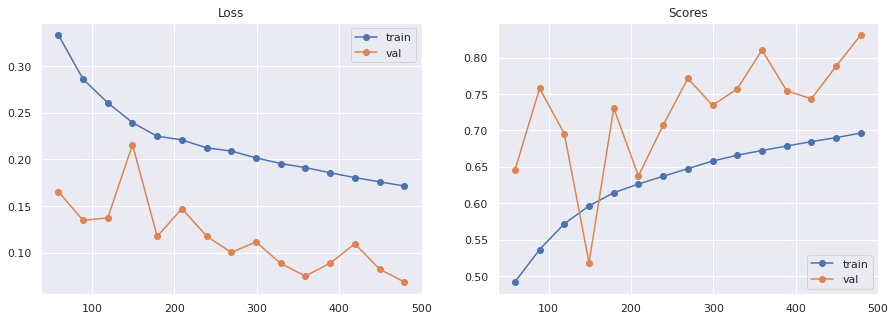

In [126]:
# show_loss_and_score(train_info)
show_loss_and_score(train_info, start_from=1)

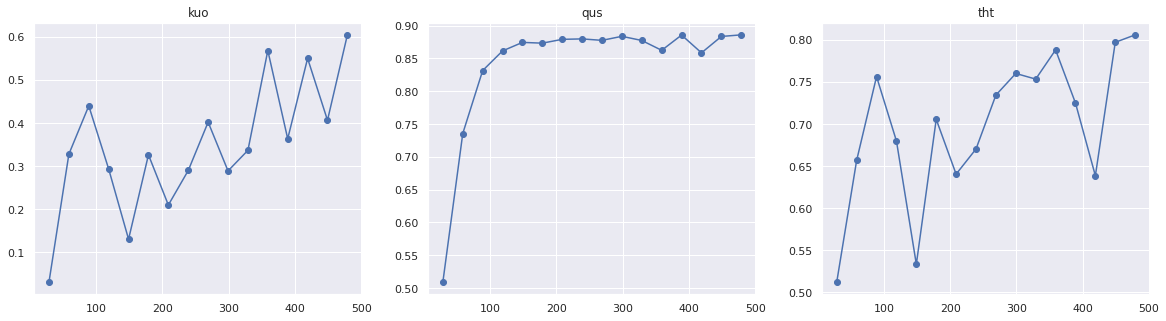

In [127]:
show_valid_score_by_flood(train_info)

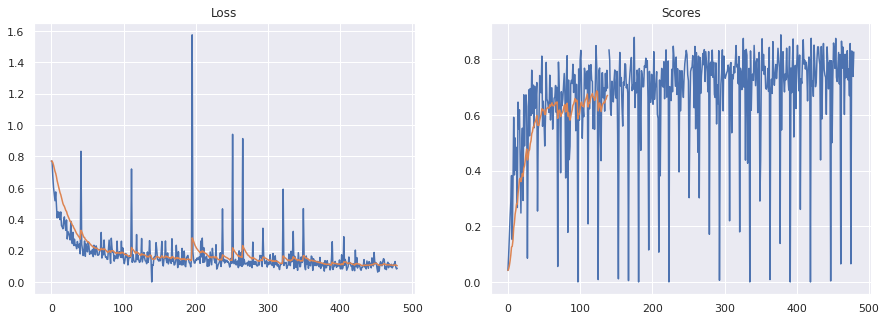

In [128]:
loss_meter = train_info['train_loss_meter']
score_meter = train_info['train_score_meter']
show_train_metrics(loss_meter, score_meter)

In [129]:
train_info = train_infos[1]

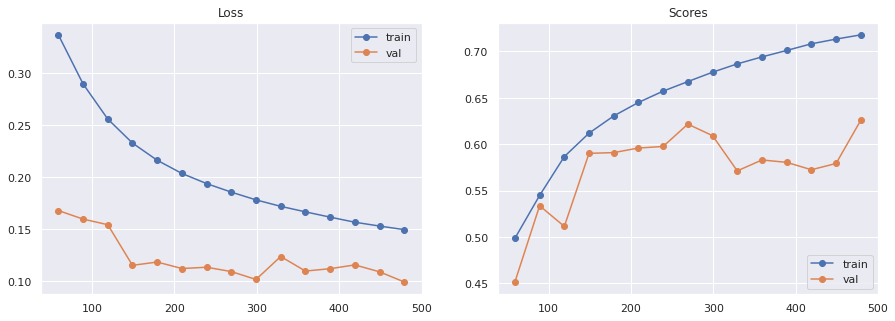

In [130]:
# show_loss_and_score(train_info)
show_loss_and_score(train_info, start_from=1)

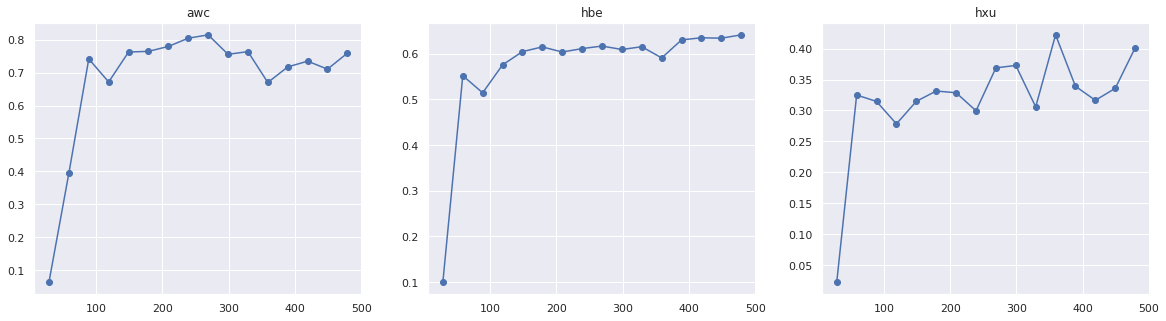

In [131]:
show_valid_score_by_flood(train_info)

In [132]:
train_info = train_infos[2]

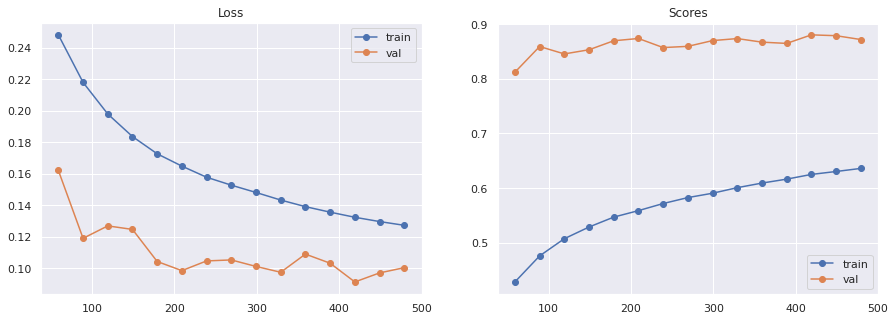

In [133]:
# show_loss_and_score(train_info)
show_loss_and_score(train_info, start_from=1)

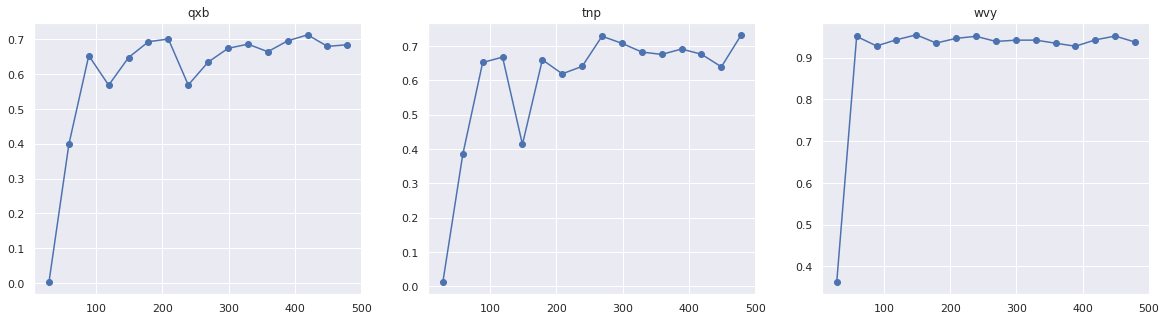

In [134]:
show_valid_score_by_flood(train_info)

In [135]:
train_info = train_infos[3]

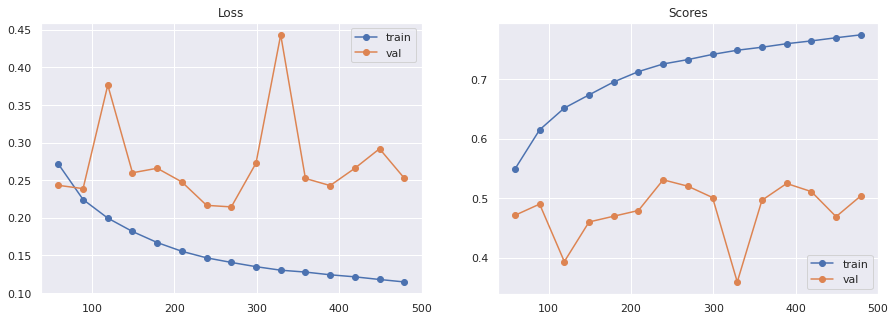

In [136]:
# show_loss_and_score(train_info)
show_loss_and_score(train_info, start_from=1)

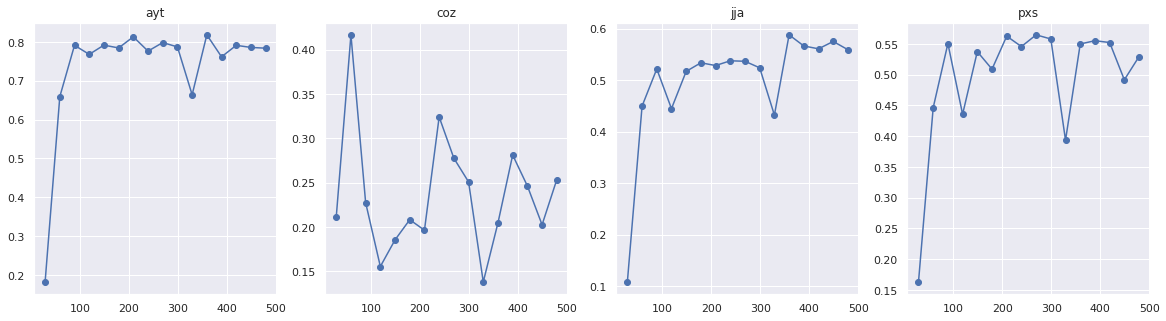

In [137]:
show_valid_score_by_flood(train_info)